In [1]:
using Plots, HDF5, Glob
using ITensors, ITensorMPS
using DataFrames
using ProgressMeter

In [2]:
function entropy_von_neumann(psi::MPS, b::Int)
    s = siteinds(psi)  
    orthogonalize!(psi, b)
    _,S = svd(psi[b], (linkind(psi, b-1), s[b]))
    SvN = 0.0
    for n in 1:dim(S, 1)
      p = S[n,n]^2
      SvN -= p * log(p)
    end
    return SvN
  end

entropy_von_neumann (generic function with 1 method)

In [25]:
N = 15

files = glob("data/dmrg_Nx_$(N)*h5")
files = filter(file -> !occursin("perturbed", file), files)
results = DataFrame(Delta=Float64[], ls=Float64[], SvN=Float64[])

@showprogress for file_path in files
    energy = 0
    # Open the H5 file and read the MPS
    h5open(file_path, "r") do file
        psi = read(file, "psi", MPS)
        energy = read(file, "energy")
        Omega = read(file, "Omega")
        Delta = read(file, "Delta")
        ls = read(file, "ls")
        # Find the dimension of psi
        dim_psi = length(psi)

        b = floor(Int, dim_psi/2)
        # psi = orthogonalize(psi, b)
        # U,S,V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
        # SvN = 0.0
        # for n=1:dim(S, 1)
        #     p = S[n,n]^2
        #     SvN -= p * log(p)
        # end
        SvN = entropy_von_neumann(psi, b)
        # println("SvN: ", SvN)
        push!(results, (Delta=Delta, ls=ls, SvN=SvN))
    end
end
nrow(results)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


8

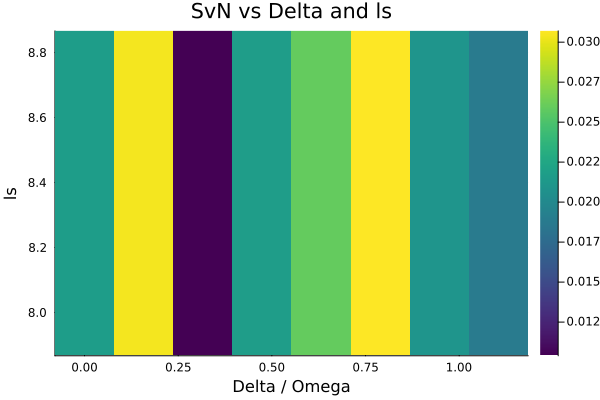

In [26]:
Delta = results.Delta
ls = results.ls
SvN = results.SvN

# Create a grid for Delta and ls
unique_Delta = unique(Delta)
unique_ls = unique(ls)

# Initialize a 2D array for SvN
z = fill(NaN, length(unique_ls), length(unique_Delta))

# Fill the 2D array with SvN values
for i in 1:length(Delta)
    delta_idx = findfirst(==(Delta[i]), unique_Delta)
    ls_idx = findfirst(==(ls[i]), unique_ls)
    z[ls_idx, delta_idx] = SvN[i]
end
Omega = 15.8;  
# Create the heatmap with the corresponding values of ls and Delta as axis labels
pmm = heatmap(sort(unique_Delta)/Omega, sort(unique_ls), z, colormap=:viridis, xlabel="Delta / Omega", ylabel="ls", title="SvN vs Delta and ls")

In [12]:
using Plots, HDF5

savefig(pmm, "plots/SvN_vs_Delta_ls_$(N).pdf")

"/home/tocqs/Ale/quera/plots/SvN_vs_Delta_ls_13.pdf"

In [73]:
if any(r -> r.Delta == Delta && r.ls == ls, eachrow(results))
    row = findfirst(r -> r.Delta == Delta && r.ls == ls, eachrow(results))
    println("Found: ", results[row, SvN])
end

In [76]:
# Set the colormap to viridis and color limits
colormap = :viridis
clims = (0, 1.5)

# Get the color palette for the colormap
palette = get_color_palette(colormap, 256)

# Normalize SvN to the range [0, 1]
normalized_SvN = (SvN - clims[1]) / (clims[2] - clims[1])
color_index = round(Int, normalized_SvN * (length(palette) - 1)) + 1
color = palette[color_index]


for ls in ls_range
    for Delta in Delta_range
        if any(r -> r.Delta == Delta && r.ls == ls, eachrow(results))
            row = findfirst(r -> r.Delta == Delta && r.ls == ls, eachrow(results))
            SvN = results[row, :SvN]
            normalized_SvN = (SvN - clims[1]) / (clims[2] - clims[1])
            color_index = round(Int, normalized_SvN * (length(palette) - 1)) + 1
            color = palette[color_index]
            println("Found: ", SvN)
            scatter!([Delta], [ls], z=[SnV], clims=clims, color=colormap, label="", colorbar=false)
        else
            scatter!([Delta], [ls], color=:black, label="", colorbar=false)
        end
    end
end

# Show the plot with no legend
plot!(legend=false)

MethodError: MethodError: no method matching -(::Vector{Float64}, ::Int64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar
The function `-` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  -(!Matched::Missing, ::Number)
   @ Base missing.jl:123
  -(!Matched::ChainRulesCore.NotImplemented, ::Any)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/6Pucz/src/tangent_arithmetic.jl:49
  -(::Any, !Matched::ChainRulesCore.NotImplemented)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/6Pucz/src/tangent_arithmetic.jl:50
  ...


In [77]:
SvN

100-element Vector{Float64}:
 0.5243418770655973
 0.01604491969729468
 0.0194412099362965
 0.21910763132019848
 0.02166797258190549
 0.49650866922890985
 0.9501498058972434
 0.804919236621952
 0.3498304123767733
 0.21948507849638182
 ⋮
 0.7871317986015816
 0.7785233904138529
 0.23457954918272628
 0.026496167513712837
 0.12111754079493174
 0.04480906705172754
 0.7461139805015115
 0.4065061072324642
 0.027607334335027687